In [1]:
import os, time, sys
import numpy as np
import torch
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import minimize
from tqdm import tqdm

device = "cuda"
SWITCH_LOSS_EPOCH = 5

# Load csv

In [2]:
PATH = "./dataset/"
train_pd = pd.read_csv(PATH + 'train_remove.csv')
# train_pd = pd.read_csv(PATH + 'train.csv')
test_pd = pd.read_csv(PATH + 'sample_submission.csv')
# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)
train_pd.head(1)

,Unnamed: 0,ImageId,PredictionString
0,0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...


# Show distribution

In [3]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        coords[-1]['id'] = int(coords[-1]['id'])
    return coords

# lens = [len(str2coords(s)) for s in train['PredictionString']]
# plt.figure(figsize=(15,6))
# seaborn.countplot(lens);
# plt.xlabel('Number of cars in image')

points_df = pd.DataFrame()
for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
    arr = []
    for ps in train_pd['PredictionString']:
        coords = str2coords(ps)
        arr += [c[col] for c in coords]
    points_df[col] = arr
print('len(points_df)', len(points_df))
points_df.head(1)

len(points_df) 49607


,x,y,z,yaw,pitch,roll
0,7.96539,3.20066,11.0225,0.254839,-2.57534,-3.10256


# 2d Visualization

In [4]:
def get_img_coords(s):
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

# train_root = "./dataset/train_images/"
# for idx,_ in enumerate(os.listdir(train_root)):
#     if idx<1:
#         name = train['ImageId'][idx]
#         img = Image.open("{}/{}.jpg".format(train_root,name))
#         coordinate = get_img_coords(train['PredictionString'][idx])
# #         print(coordinate)
#         fig,axes = plt.subplots(1,1,figsize=(7,7))
#         axes.imshow(img)
#         axes.scatter(*coordinate,color='red',s=30)
#         plt.pause(.1)
#     else:
#         break

# Given x,z -> get y

In [5]:
zy_slope = LinearRegression()
X = points_df[['z']]
y = points_df['y']
zy_slope.fit(X, y)
print('MAE without x:', mean_absolute_error(y, zy_slope.predict(X)))

# Will use this model later
xzy_slope = LinearRegression()
X = points_df[['x', 'z']]
y = points_df['y']
xzy_slope.fit(X, y)
print('MAE with x:', mean_absolute_error(y, xzy_slope.predict(X)))

print('\ndy/dx = {:.3f}\ndy/dz = {:.3f}'.format(*xzy_slope.coef_))

MAE without x: 0.6557414214081686
MAE with x: 0.4484400166066854

dy/dx = 0.051
dy/dz = 0.169


# 3d Visualization

In [6]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image

def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
#         cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
        cv2.circle(image, (p_x, p_y), int(30), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

def cv_read(file_name,fast_mode=False):
    img = cv2.imread(file_name)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        
#         print(Rt)
#         print(t)
        
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]

#         print(Rt)
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    return img

# train_root = "./dataset/train_images/"
# for idx,_ in enumerate(os.listdir(train_root)):
#     if idx<1:
#         name = train['ImageId'][idx]
#         img = cv_read("{}/{}.jpg".format(train_root,name))
#         coordinate = str2coords(train['PredictionString'].iloc[idx])
#         pose_info = visualize(img,coordinate)

#         print(np.shape(img))
#         fig,axes = plt.subplots(1,2,figsize=(12,12))
#         axes[0].imshow(img)
#         img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
#         axes[1].imshow(img_vis)
#         plt.pause(.1)
#     else:
#         break
    

# Image preprocessing

In [7]:
# IMG_WIDTH = 1024
# IMG_HEIGHT = 320  #IMG_HEIGHT = IMG_WIDTH // 16 * 5

IMG_WIDTH = 1536
IMG_HEIGHT = 512
MODEL_SCALE = 8

# IMG_WIDTH = 2048
# IMG_HEIGHT = IMG_WIDTH // 4

# IMG_WIDTH = 512
# IMG_HEIGHT = 512
# MODEL_SCALE = 8

def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

def rotate(x, angle): 
    x = x + angle 
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi 
    return x

def _regr_preprocess(regr_dict, flip=False):
    if flip:
        for k in ['x', 'pitch', 'roll']:
            regr_dict[k] = -regr_dict[k]
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img, flip=False):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 6]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    if flip:
        img = img[:,::-1]
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels, flip=False):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 6) * IMG_WIDTH / (img.shape[1] * 4/3) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict, flip)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    if flip:
        mask = np.array(mask[:,::-1])
        regr = np.array(regr[:,::-1])
    return mask, regr

img.shape (2710, 3384, 3) std: 0.29817882
mask.shape (64, 192) std: 0.020167684
regr.shape (64, 192, 7) std: 0.008528283


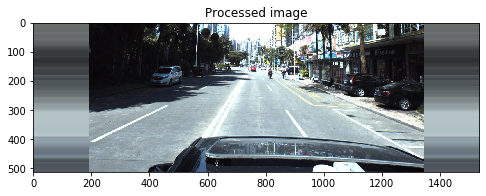

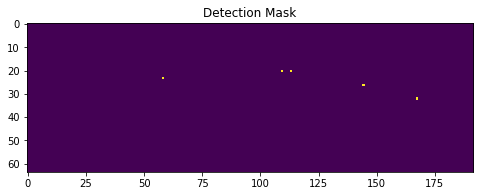

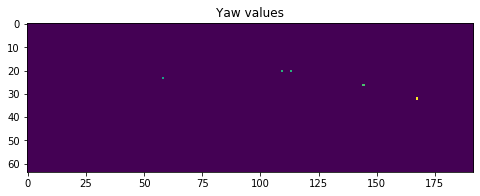

In [8]:
PATH = './dataset/'
img = imread(PATH + 'train_images/' + train_pd['ImageId'][0] + '.jpg')
# img = imread(PATH + 'masked_train/' + train['ImageId'][0] + '.jpg')

img_pre = preprocess_image(img)
mask, regr = get_mask_and_regr(img, train_pd['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img_pre))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

size = 8

plt.figure(figsize=(size,size))
plt.title('Processed image')
plt.imshow(img_pre)
plt.show()

plt.figure(figsize=(size,size))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(size,size))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

# Transform and Dataloader 

In [9]:
from imgaug import augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapOnImage
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
#         iaa.Scale((640, 480)),
#         iaa.Fliplr(0.5),
#         iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 0.75))),
#         iaa.Sometimes(0.1, iaa.AverageBlur(1.2)),
#         iaa.Sometimes(1, iaa.Affine(rotate=(-20, 20),order=[0, 1],translate_px={"x":(-2, 2),"y":(-2,2)},mode='symmetric')),
#         iaa.Sometimes(0.2,iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.25))),
#         iaa.Sometimes(0.1, iaa.SaltAndPepper(0.05,False)),
#         iaa.Invert(0.5),
#         iaa.Add((-5, 5)), # change brightness of images (by -10 to 10 of original value)
        iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(0,0.015*255)),
#         iaa.Sometimes(0.2,iaa.GammaContrast(2))
#         iaa.AddToHueAndSaturation(from_colorspace="RGB",value=(-20, 20))  #Hue-> color, saturation -> saido
    ])
    def __call__(self, img, mask=None):
        img = np.array(img)        
        return self.aug.augment_image(image=img)
#         return self.aug(image=img, segmentation_maps=label)



# train distribution: mean=[0.2732385  0.28948802 0.31470126],std=[0.19721317 0.20766443 0.20611505]
# test distribution: mean=[0.26370072 0.28066522 0.30648127],std=[0.19954063 0.20964707 0.2084653 ]
trans = transforms.Compose([
#         transforms.ColorJitter(0.6,0.6,0.6,0.5),
#         transforms.RandomAffine(degrees=20,translate=(0.25,0.25),scale=[0.65,1.1],shear=15), #after 60k
#         transforms.RandomAffine(degrees=15,translate=(0.25,0.25),scale=[0.7,1.1],shear=8), #60k baseline
        ImgAugTransform(),
        lambda x: Image.fromarray(x),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.2732385,0.28948802,0.31470126],std=[0.19721317,0.20766443,0.20611505])
    ])

trans_val = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
        transforms.Normalize(mean=[0.2732385,0.28948802,0.31470126],std=[0.19721317,0.20766443,0.20611505])
    ])

trans_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.26370072,0.28066522,0.30648127],std=[0.19954063,0.20964707,0.2084653])
    ])


In [10]:
train_pd = pd.read_csv("./dataset/train_remove.csv")
# train_pd = pd.read_csv("./dataset/train.csv")
test_pd = pd.read_csv("./dataset/sample_submission.csv")

class ADDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None,indices=None):
        self.is_validate = is_validate
#         self.data = global_car_data
        if data_len == None:
            data_len = len(self.data)
        
        self.indices = indices
        if self.is_validate:
            self.len = int(np.ceil(data_len*validate_rate))
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_val
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            self.transform = trans
        
    def __getitem__(self, idx):
#         print(idx)
        idx += self.offset
        idx = self.indices[idx]
#         img = cv2.imread('./dataset/masked_train/' + train_pd['ImageId'].iloc[idx] + '.jpg')
        img = cv2.imread('./dataset/train_images/' + train_pd['ImageId'].iloc[idx] + '.jpg')
    
        img = np.array(img[:,:,::-1])

        mask, regr = get_mask_and_regr(img, train_pd['PredictionString'][idx])
        img_pre = preprocess_image(img)  #shape(batch,512,512), #range: [0~1]
        
        img_pil = (img_pre*255).astype('uint8')
        img_pil = Image.fromarray(img_pil)  #ndarray: Take uint8 as input, range[0~255], #imgpil -> (512,512,3), (0~255)
        img_pre_trans = self.transform(img_pil)
        
#         print(np.shape(img))        #(2710, 3384, 3)
#         print(np.shape(img_pre))    #(320, 1024, 3)
#         print(np.shape(mask))       #(40, 128)
#         print(np.shape(regr))       #(40, 128,7)
        
        regr = np.transpose(regr,(2,0,1))
        
#         label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)
#         img_pre = torch.as_tensor(img_pre, dtype=torch.float32) #For distribution computing

        return img_pre_trans, mask, regr

    def __len__(self):
        return self.len

    
class TestDataset(Dataset):
    def __init__(self,data_len=None):
        self.transform = trans_test
        self.len = data_len
        
    def __getitem__(self, idx):
#         img = cv_read('./dataset/masked_test/{}.jpg'.format(test_pd['ImageId'].iloc[idx]))
        img = cv_read('./dataset/test/{}.jpg'.format(test_pd['ImageId'].iloc[idx]))
        
        img = np.array(img[:,:,::-1])
        img_pre = preprocess_image(img)  #shape(batch,512,512), #range: [0~1]
        img_pil = (img_pre*255).astype('uint8')
        img_pil = Image.fromarray(img_pil)  #ndarray: Take uint8 as input, range[0~255], #imgpil -> (512,512,3), (0~255)
        img_pre_trans = self.transform(img_pil)        

        return img_pre_trans, []   #return img_pre_trans, _ will cause strange behavior (load very slow after 10 batch)

    def __len__(self):
        return self.len
    

# Dataset Ditribution

In [11]:
# train distribution: mean=[0.08229437],std=[0.23876116]
# dig augmented distribution: mean=[0.09549136],std=[0.24336776]
# train large distribution: mean=[0.08889286],std=[0.24106438]

def get_dataset_mean_std(dataloader):
    print("Calculate distribution:")
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in dataloader:
        img = data[0].to(device)
        
#         print(np.shape(img)) #(batch,3,512,512)
        
        batch_samples = img.size(0)
        img = img.contiguous().view(batch_samples, img.size(1), -1)
        mean += img.mean(2).sum(0)
        std += img.std(2).sum(0)
        nb_samples += batch_samples
        if nb_samples%640 == 0:
            print("Finished:", nb_samples)
            
    print("num of samples:",nb_samples)
    mean /= nb_samples
    std /= nb_samples
#     print("Average mean:",mean)
#     print("Average std:", std)
    return mean.cpu().numpy(), std.cpu().numpy()


# EfficientNet

In [12]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b0')
#         self.base_model = EfficientNet.from_pretrained('efficientnet-b7')
        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        ###eff-b0
        self.up1 = up(1282 + 1024, 512)
        self.up2 = up(512 + 512, 256)
        
        ###eff-b7
#         self.up1 = up(2562 + 1024, 512)
#         self.up2 = up(512 + 512, 256)
        
        
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        x_center = x[:, :, :, IMG_WIDTH // 8: -IMG_WIDTH // 8]
        feats = self.base_model.extract_features(x_center)
        bg = torch.zeros([feats.shape[0], feats.shape[1], feats.shape[2], feats.shape[3] // 8]).to(device)
        feats = torch.cat([bg, feats, bg], 3)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
#         print("feats:",feats.size())
#         print("x4:", x4.size())
#         print("x3:", x3.size())

        ###eff-b0
#         feats: torch.Size([1, 1282, 16, 44])
#         x4: torch.Size([1, 1024, 32, 96])
#         x3: torch.Size([1, 512, 64, 192])

        ###eff-b7
#         feats: torch.Size([1, 2562, 16, 44])
#         x4: torch.Size([1, 1024, 32, 96])
#         x3: torch.Size([1, 512, 64, 192])
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

# Centernet by Duan

In [13]:
# class Network(nn.Module):
#     def __init__(self, model, loss):
#         super(Network, self).__init__()

#         self.model = model
#         self.loss  = loss

#     def forward(self, xs, ys, **kwargs):
#         preds = self.model(*xs, **kwargs)
#         loss_kp  = self.loss(preds, ys, **kwargs)
#         return loss_kp

# # for model backward compatibility
# # previously model was wrapped by DataParallel module
# class DummyModule(nn.Module):
#     def __init__(self, model):
#         super(DummyModule, self).__init__()
#         self.module = model

#     def forward(self, *xs, **kwargs):
#         return self.module(*xs, **kwargs)

# class NetworkFactory(object):
#     def __init__(self, db):
#         super(NetworkFactory, self).__init__()

#         module_file = "models.{}".format(system_configs.snapshot_name)
#         print("module_file: {}".format(module_file))
#         nnet_module = importlib.import_module(module_file)

#         self.model   = DummyModule(nnet_module.model(db))
#         self.loss    = nnet_module.loss
#         self.network = Network(self.model, self.loss)
# #         self.network = DataParallel(self.network, chunk_sizes=system_configs.chunk_sizes).cuda()

#         total_params = 0
#         for params in self.model.parameters():
#             num_params = 1
#             for x in params.size():
#                 num_params *= x
#             total_params += num_params
#         print("total parameters: {}".format(total_params))

#         if system_configs.opt_algo == "adam":
#             self.optimizer = torch.optim.Adam(
#                 filter(lambda p: p.requires_grad, self.model.parameters())
#             )
#         elif system_configs.opt_algo == "sgd":
#             self.optimizer = torch.optim.SGD(
#                 filter(lambda p: p.requires_grad, self.model.parameters()),
#                 lr=system_configs.learning_rate, 
#                 momentum=0.9, weight_decay=0.0001
#             )
#         else:
#             raise ValueError("unknown optimizer")

#     def cuda(self):
#         self.model.cuda()

#     def train_mode(self):
#         self.network.train()

#     def eval_mode(self):
#         self.network.eval()

#     def train(self, xs, ys, **kwargs):
#         xs = [x for x in xs]
#         ys = [y for y in ys]

#         self.optimizer.zero_grad()
#         loss_kp = self.network(xs, ys)
#         loss        = loss_kp[0]
#         focal_loss  = loss_kp[1]
#         pull_loss   = loss_kp[2]
#         push_loss   = loss_kp[3]
#         regr_loss   = loss_kp[4]
#         loss        = loss.mean()
#         focal_loss  = focal_loss.mean()
#         pull_loss   = pull_loss.mean()
#         push_loss   = push_loss.mean()
#         regr_loss   = regr_loss.mean()
#         loss.backward()
#         self.optimizer.step()
#         return loss, focal_loss, pull_loss, push_loss, regr_loss

#     def validate(self, xs, ys, **kwargs):
#         with torch.no_grad():
#             xs = [x.cuda(non_blocking=True) for x in xs]
#             ys = [y.cuda(non_blocking=True) for y in ys]

#             loss_kp = self.network(xs, ys)
#             loss       = loss_kp[0]
#             focal_loss = loss_kp[1]
#             pull_loss  = loss_kp[2]
#             push_loss  = loss_kp[3]
#             regr_loss  = loss_kp[4]
#             loss = loss.mean()
#             return loss

#     def test(self, xs, **kwargs):
#         with torch.no_grad():
#             xs = [x.cuda(non_blocking=True) for x in xs]
#             return self.model(*xs, **kwargs)

#     def set_lr(self, lr):
#         print("setting learning rate to: {}".format(lr))
#         for param_group in self.optimizer.param_groups:
#             param_group["lr"] = lr

#     def load_pretrained_params(self, pretrained_model):
#         print("loading from {}".format(pretrained_model))
#         with open(pretrained_model, "rb") as f:
#             params = torch.load(f)
#             self.model.load_state_dict(params)

#     def load_params(self, iteration):
#         cache_file = system_configs.snapshot_file.format(iteration)
#         print("loading model from {}".format(cache_file))
#         with open(cache_file, "rb") as f:
#             params = torch.load(f)
#             self.model.load_state_dict(params)

#     def save_params(self, iteration):
#         cache_file = system_configs.snapshot_file.format(iteration)
#         print("saving model to {}".format(cache_file))
#         with open(cache_file, "wb") as f:
#             params = self.model.state_dict()
#             torch.save(params, f) 
            
# # from CenterNet.models.CenterNet_52 import model as centernet_52_model
# # center_model   = DummyModule(centernet_52_model(db=None))
# # center_loss    = nnet_module.loss
# # network = Network(center_model, center_loss)            

# Criterion

In [14]:
from CenterNet.src.lib.models.losses import FocalLoss, RegL1Loss, RegLoss, RegWeightedL1Loss, RegLoss_without_ind
f_loss = FocalLoss()
l1_loss = RegLoss_without_ind()

def criterion_new(prediction, mask, regr, weight=0.5, size_average=True):
    pred_mask = torch.sigmoid(prediction[:, 0])
    mask_loss = f_loss(pred_mask, mask)

    pred_regr = prediction[:, 1:]
    regr_loss = l1_loss(pred_regr,regr,mask)
    
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss


def criterion(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

# Dataloader

In [15]:
###Single dataset
vr = 0.1
batch_size = 2
num_workers = 8

train_pd = pd.read_csv("./dataset/train_remove.csv")
indices_len = len(train_pd)
print("len of train indices:",indices_len)
indices = np.arange(indices_len)
train_dataset = ADDataset(data_len=indices_len,is_validate=False,validate_rate=vr,indices=indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# mean, std = get_dataset_mean_std(train_loader)
# print("train distribution: mean={},std={}".format(mean, std))
# train distribution: mean=[0.2732385  0.28948802 0.31470126],std=[0.19721317 0.20766443 0.20611505]

val_dataset = ADDataset(data_len=indices_len,is_validate=True,validate_rate=vr,indices=indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# test_pd = pd.read_csv("./dataset/sample_submission.csv")
# indices_len = len(test_pd)
# print("len of test indices:",indices_len)
# test_dataset = TestDataset(data_len=indices_len)
# test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False, num_workers=0)
# mean, std = get_dataset_mean_std(test_loader)
# print("test distribution: mean={},std={}".format(mean, std))
# test distribution: mean=[0.26370072 0.28066522 0.30648127],std=[0.19954063 0.20964707 0.2084653 ]


len of train indices: 4257


# Train Model

In [ ]:
# model = CentResnet(8)
model = MyUNet(8)
model.cuda()
# model.load_state_dict(torch.load("./saved_model/Ep5_loss8.3501"))
# summary(model, input_size=(3,512,2048))

# img, mask, regr = train_dataset[0]
# size = 8
# img = img[None]  #(1,3,512,512),  img[None] = img[np.newaxis]
# with torch.no_grad():
#     output = model(img.to(device))  #(1,8,64,192)
#     logits = output.cpu().numpy()
# print(output.size())

# print(np.max(logits))
# plt.figure(figsize=(size,size))
# plt.title('Model predictions')
# plt.imshow(logits)
# plt.show()


In [ ]:
# model = None
# from numba import cuda
# cuda.select_device(0)
# cuda.close()
# torch.cuda.empty_cache()

lr = 1e-4
lr_period = 5
epochs = 200
val_freq = 1
optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9,0.99))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4,factor=0.3)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(epochs, 10) * len(train_loader) // 3, gamma=0.1)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=lr_period,T_mult=1,eta_min=1e-6) #original 

min_loss = 100000
best_model_dict = None

import gc
history = pd.DataFrame()

for ep in range(epochs):
    model.train()
#     torch.cuda.empty_cache()
#     gc.collect()
    
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        optimizer.zero_grad()
        
#         print(img_batch.size())  #(batch,3,512,2048)
#         print(mask_batch.size()) #(batch,64,256)
#         print(regr_batch.size()) #(batch,7,64,256)
        output = model(img_batch) 
#         print(output.size())    #(batch,8,64,256)

#         loss, mask_loss , regr_loss = criterion(output, mask_batch, regr_batch)
        loss, mask_loss , regr_loss = criterion_new(output, mask_batch, regr_batch)
#         print(loss.item())
#         print(mask_loss.item())
#         print(regr_loss.item())
    
        if history is not None:
            history.loc[ep + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        loss.backward()
        optimizer.step()
    print('Epoch:{} lr:{:.5f} loss:{:.6f} mloss:{:.6f} rloss{:.6f}'.
          format(ep,optimizer.param_groups[0]['lr'],loss.data,mask_loss.data,regr_loss.data))
#     lr_scheduler.step()

    if ep%val_freq==0:
        model.eval()
        val_loss = 0
        data_num = 0
        with torch.no_grad():
            for img_batch, mask_batch, regr_batch in tqdm(val_loader):
                img_batch = img_batch.to(device)
                mask_batch = mask_batch.to(device)
                regr_batch = regr_batch.to(device)
                output = model(img_batch)
                val_loss += criterion_new(output, mask_batch, regr_batch, size_average=False)[0].data
                img_batch.size()
                data_num += img_batch.size(0)
                
        val_loss /= data_num
        print('Val loss: {:.4f}'.format(val_loss))
        
        lr_scheduler.step(val_loss)
        
        if val_loss < min_loss:
            min_loss = val_loss
            best_model_dict = model.state_dict()
            print("./saved_model/Ep:{}_loss{:.4f}".format(ep,min_loss))
            torch.save(best_model_dict, "./saved_model/Ep{}_loss{:.4f}".format(ep,min_loss))
        
#         if history is not None:
#             history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()


  0%|          | 0/1916 [00:00<?, ?it/s]/home/ccchang/miniconda3/envs/pytorch2/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 36%|███▌      | 688/1916 [05:39<09:54,  2.07it/s]

In [ ]:
# history['train_loss'].iloc[100:].plot()
# torch.cuda.empty_cache()
model = CentResnet(8)
model.cuda()
# model.load_state_dict(torch.load("./saved_model/Ep6_loss8.2134"))
# model.eval()

In [ ]:
mean,std = [0.2732385,0.28948802,0.31470126],[0.19721317,0.20766443,0.20611505] #train 
# mean,std =[0.26370072,0.28066522,0.30648127],[0.19954063,0.20964707,0.2084653 ] #test
mean,std = np.array(mean), np.array(std)

def denormalize(img):
    img = transforms.Normalize(-1*mean/std, 1/std)(img) #denormalize
    return img

img, mask, regr = train_dataset[1]
# img, mask, regr = val_dataset[0]
# img, _ = test_dataset[1]

size = 8
plt.figure(figsize=(size,size))
plt.title('Input image')

img_show = denormalize(img).permute(1,2,0).cpu().numpy()
up = np.max(img_show)
low = np.min(img_show)
print(up,low)
plt.imshow(img_show)
plt.show()

plt.figure(figsize=(size,size))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

# img = img[None]  #(1,3,512,512),  img[None] = img[np.newaxis]
# print(np.shape(img))
# with torch.no_grad():
#     output = model(img.to(device))  #(1,8,64,256)
#     logits = output[0][0].data.cpu().numpy()      

# print(output.size())
# print(np.max(logits))

# plt.figure(figsize=(size,size))
# plt.title('Model predictions')
# plt.imshow(logits)
# plt.show()

# plt.figure(figsize=(size,size))
# plt.title('Model predictions thresholded')
# plt.imshow(logits > 0)
# plt.show()

# 2d to 3d inference test

In [18]:
DISTANCE_THRESH_CLEAR = 2

img = imread("./dataset/train_images/{}.jpg".format(train['ImageId'].iloc[0]))
IMG_SHAPE = img.shape

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction,logits_thresh=0):
    logits = prediction[0]
    regr_output = prediction[1:]
#     print("logits min:", np.min(logits), " logits max: ", np.max(logits))
    points = np.argwhere(logits > logits_thresh)
    
#     plt.figure(figsize=(15,6))
#     seaborn.countplot(np.array(logits).reshape(-1,1).squeeze(1))
#     plt.pause(.1)
#     stop
    
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

# Show Inference result on real Image

In [ ]:
# torch.cuda.empty_cache()
# gc.collect()
data_len = len(train_pd)
test_pd = pd.read_csv("./dataset/sample_submission.csv")

if __name__ == '__main__':
    with torch.no_grad():
        for i in range(105,115):
#             img, mask, regr = val_dataset[i]
            img, _ = test_dataset[i]
            
            img = img.to(device).unsqueeze(0)
            output = model(img).cpu().numpy()
#             coords_pred = extract_coords(output[0],logits_thresh=-1.25)
            coords_pred = extract_coords(output[0],logits_thresh=0)
            coords_true = extract_coords(np.concatenate([mask[None], regr], 0))

            offset = int(data_len*(1-vr))
            offset = 0
            idx = i+offset
#             img_origin = imread("./dataset/train_images/{}.jpg".format(train_pd['ImageId'].iloc[idx]))
            img_origin = imread("./dataset/test_images/{}.jpg".format(test_pd['ImageId'].iloc[idx]))
            print(test_pd['ImageId'].iloc[idx])

            print("ground true shape", np.shape(coords_true))
            print("pred shape", np.shape(coords_pred))
        #     print(coords_true)
        #     print("")
        #     print(coords_pred)
            fig, axes = plt.subplots(1,2, figsize=(16,16))
            axes[0].set_title('Ground truth')
            axes[0].imshow(visualize(img_origin, coords_true))
            axes[1].set_title('Prediction')
            axes[1].imshow(visualize(img_origin, coords_pred))
            plt.pause(.1)

# Submission

In [ ]:
ths = [-1,-0.1]
model = CentResnet(8)
model.cuda()
model.load_state_dict(torch.load("./saved_model/res50_vr0.05_imgaugv2/Ep7_loss8.9245"))
model.eval()

for threshold in ths:
    predictions = []
    test_pd = pd.read_csv("./dataset/sample_submission.csv")
    indices_len = len(test_pd)
    print("indices_len",indices_len)
    test_dataset = TestDataset(data_len=indices_len)
    test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=0)
    with torch.no_grad():
        for img,_ in tqdm(test_loader):
            img = img.to(device)
            output = model(img).cpu().numpy()
            for out in output:
                coords = extract_coords(out,logits_thresh=threshold)
                s = coords2str(coords)
                predictions.append(s)

    print(np.shape(predictions))
    test = pd.read_csv(PATH + 'sample_submission.csv')
    test['PredictionString']= predictions
    file_name = "predictions_th{}.csv".format(threshold)
    test.to_csv(file_name, index=False)
    test.head()        

  0%|                                                  | 0/506 [00:00<?, ?it/s]

indices_len 2021


 25%|█████████▉                              | 125/506 [03:27<10:29,  1.65s/it]